# DA5401: Assignment 7
## Author: Ojas Phadake
## Roll No: CH22B007

This assignment challenges us to apply and interpret Receiver Operating
Characteristic (ROC) curves and Precision-Recall Curves (PRC) for model selection in a multi-class, complex classification environment. You will compare a diverse set of classifiers, including those known to perform poorly, requiring careful analysis of the curves rather than
relying solely on simple accuracy.

Dataset Used:

Landsat Satellite Dataset: A classic multi-class problem with six primary classes.
Ignore the class label that says “all types present”.
**Citation**: Blake, C. and Merz, C.J. (1998). UCI Repository of machine learning databases. Irvine, CA: University of California, Department of Information and Computer Science. [Link to the Dataset.](https://archive.ics.uci.edu/dataset/146/statlog+landsat+satellite)


## Import libraries

In [31]:
pip install ucimlrepo

import pandas as pd
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## 2. Tasks
### Part A: Data Preparation and Baseline

### Load and Prepare Data

In [5]:
statlog_landsat_satellite = fetch_ucirepo(id=146)

X = statlog_landsat_satellite.data.features
y = statlog_landsat_satellite.data.targets

print("Features (X) Head:")
print(X.head())

print("\nTargets (y) Head:")
y.head()

Features (X) Head:
   Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0          92         115         120          94          84         102   
1          84         102         106          79          84         102   
2          84         102         102          83          80         102   
3          80         102         102          79          84          94   
4          84          94         102          79          80          94   

   Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute27  \
0         106          79          84          102  ...          134   
1         102          83          80          102  ...          128   
2         102          79          84           94  ...          113   
3         102          79          80           94  ...          104   
4          98          76          80          102  ...          104   

   Attribute28  Attribute29  Attribute30  Attribute31  Attribute32  \
0          104 

,class
0,3
1,3
2,3
3,3
4,3


In [7]:
y.value_counts()

,count
class,
1,1533
7,1508
3,1358
5,707
2,703
4,626


In [8]:
scaler = StandardScaler()

X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

print("Standardized Features (X_scaled) Head:")
print(X_scaled.shape)
X_scaled.head()

Standardized Features (X_scaled) Head:
(6435, 36)


,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute27,Attribute28,Attribute29,Attribute30,Attribute31,Attribute32,Attribute33,Attribute34,Attribute35,Attribute36
0,1.661177,1.372574,1.244208,0.603682,1.095101,0.819608,0.413457,-0.184648,1.120130,0.835806,...,2.094080,1.123729,1.412427,1.656979,1.729516,0.912814,1.139685,1.058116,0.843046,0.235904
1,1.073150,0.804404,0.403097,-0.190128,1.095101,0.819608,0.173402,0.026552,0.823164,0.835806,...,1.732879,0.913090,1.115947,1.044165,0.831474,0.230119,1.139685,0.707472,0.303936,-0.183981
2,1.073150,0.804404,0.162779,0.021555,0.800119,0.819608,0.173402,-0.184648,1.120130,0.485857,...,0.829875,0.228512,1.115947,0.693985,0.292649,-0.190001,1.139685,0.707472,0.303936,-0.183981
3,0.779136,0.804404,0.162779,-0.190128,1.095101,0.470029,0.173402,-0.184648,0.823164,0.485857,...,0.288073,-0.192767,1.115947,0.693985,0.292649,-0.190001,1.139685,0.882794,0.303936,-0.183981
4,1.073150,0.454761,0.162779,-0.190128,0.800119,0.470029,-0.066654,-0.343047,0.823164,0.835806,...,0.288073,-0.192767,1.115947,0.869075,0.292649,-0.190001,0.766566,1.058116,0.603442,0.235904


### Train/Test Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

### Train All Models

In [42]:
trained_models = {}

## 1. K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
trained_models['KNN'] = knn
print(f"✅ Trained KNN (k=5)")

## 2. Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
trained_models['Decision Tree'] = dtc
print(f"✅ Trained Decision Tree")

## 3. Dummy Classifier (Prior)
# Strategy 'prior' predicts the class that occurs most often in the training data
dummy = DummyClassifier(strategy='prior', random_state=42)
dummy.fit(X_train, y_train)
trained_models['Dummy (Prior)'] = dummy
print(f"✅ Trained Dummy Classifier (Strategy='prior')")

## 4. Logistic Regression
# Set max_iter for convergence, solver 'lbfgs' is default for multiclass
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
trained_models['Logistic Regression'] = lr
print(f"✅ Trained Logistic Regression")

## 5. Naive Bayes (Gaussian)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
trained_models['Gaussian NB'] = gnb
print(f"✅ Trained Gaussian Naive Bayes")

## 6. Support Vector Machine (SVC)
# probability=True is required to enable .predict_proba() for ROC/PRC analysis
svc = SVC(probability=True, random_state=42)
svc.fit(X_train, y_train)
trained_models['SVC (Probability=True)'] = svc
print(f"✅ Trained SVC (Probability=True)")

print("\n--- Training Complete ---")

✅ Trained KNN (k=5)
✅ Trained Decision Tree
✅ Trained Dummy Classifier (Strategy='prior')
✅ Trained Logistic Regression
✅ Trained Gaussian Naive Bayes
✅ Trained SVC (Probability=True)

--- Training Complete ---


### Baseline Evaluation

In [17]:
results = {}

print(f"{'Model':<20}{'Overall Accuracy':<20}{'Weighted F1-Score'}")
print("-" * 60)

for name, model in trained_models.items():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[name] = {'Accuracy': accuracy, 'F1_Weighted': f1}

    print(f"{name:<30}{accuracy: <20.4f}{f1:.4f}")

results_df = pd.DataFrame(results).T

Model               Overall Accuracy    Weighted F1-Score
------------------------------------------------------------
KNN                           0.9109              0.9100
Decision Tree                 0.8358              0.8366
Dummy (Prior)                 0.2382              0.0917
Logistic Regression           0.8586              0.8513
Gaussian NB                   0.7934              0.8001
SVC (Probability=True)        0.8975              0.8960


## Part B: ROC Analysis for Model Selection
### Multi-Class ROC Calculation

The **One-vs-Rest (OvR)** approach is the standard method for extending the Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) from a binary (two-class) problem to a **multi-class** setting.

It works by decomposing the multi-class problem (with $N$ classes) into $N$ separate binary classification problems.

#### 1. OvR ROC Curve Generation

For a multi-class problem with classes $C_1, C_2, \ldots, C_N$:

1.  **Iterate Over Classes:** The process is repeated $N$ times, once for each class.
2.  **Binary Transformation:** In each iteration $i$, class $C_i$ is temporarily designated as the **positive class**, and all other $N-1$ classes ($C_{\text{rest}}$) are grouped together and designated as the **negative class**.
3.  **Probability Scores:** The classifier must output a **probability score** (or confidence score) for each class. In the OvR scenario for class $C_i$, we use the model's predicted probability $P(\text{Class } C_i)$ as the score for the positive class.
4.  **Calculate Binary Metrics:** Using the true binary labels (Is it $C_i$ or not $C_i$?) and the probability scores $P(\text{Class } C_i)$, the True Positive Rate (TPR) and False Positive Rate (FPR) are calculated across all possible threshold settings, just as in a standard binary ROC curve.
    * **True Positives (TP):** Samples actually belonging to $C_i$ that are predicted to be $C_i$.
    * **False Positives (FP):** Samples actually belonging to $C_{\text{rest}}$ that are predicted to be $C_i$.
5.  **Generate $N$ Curves:** This process yields **$N$ individual ROC curves**, one for each class, plotting the performance of distinguishing that class from all others.

***

#### 2. AUC Calculation and Averaging

Since the OvR strategy produces $N$ binary AUC scores (one for each class), these scores must be aggregated into a single metric for overall model evaluation. The two most common methods are **Macro-Averaging** and **Micro-Averaging**.

##### A. Macro-Averaged AUC

The macro-average AUC treats all classes equally, regardless of their size in the dataset.

$$\text{Macro-AUC} = \frac{1}{N} \sum_{i=1}^{N} \text{AUC}_i$$

* **Calculation:** Calculate the AUC for each of the $N$ individual ROC curves ($\text{AUC}_i$), and then take the simple **arithmetic mean** of those $N$ values.
* **Use Case:** This method is useful when all classes are considered equally important, and it is less sensitive to class imbalance.

##### B. Micro-Averaged AUC

The micro-average AUC aggregates the predictions for all classes and computes the ROC curve globally.

1.  The True Positives (TP), False Positives (FP), and False Negatives (FN) for all $N$ binary OvR problems are summed up across all classes:
    * $$\text{Total TP} = \sum_{i=1}^{N} \text{TP}_i$$
    * $$\text{Total FP} = \sum_{i=1}^{N} \text{FP}_i$$
2.  A single global ROC curve is then generated by plotting the **Total TPR** ($\frac{\text{Total TP}}{\text{Total TP} + \text{Total FN}}$) against the **Total FPR** ($\frac{\text{Total FP}}{\text{Total FP} + \text{Total TN}}$) across all thresholds.
3.  The **Micro-AUC** is the area under this single curve.
* **Note:** For micro-averaging, the Micro-AUC is equivalent to the overall **classification accuracy** when the class output is $\in \{0, 1\}$. It is often dominated by the performance of the majority class in imbalanced datasets.

### Plotting ROC

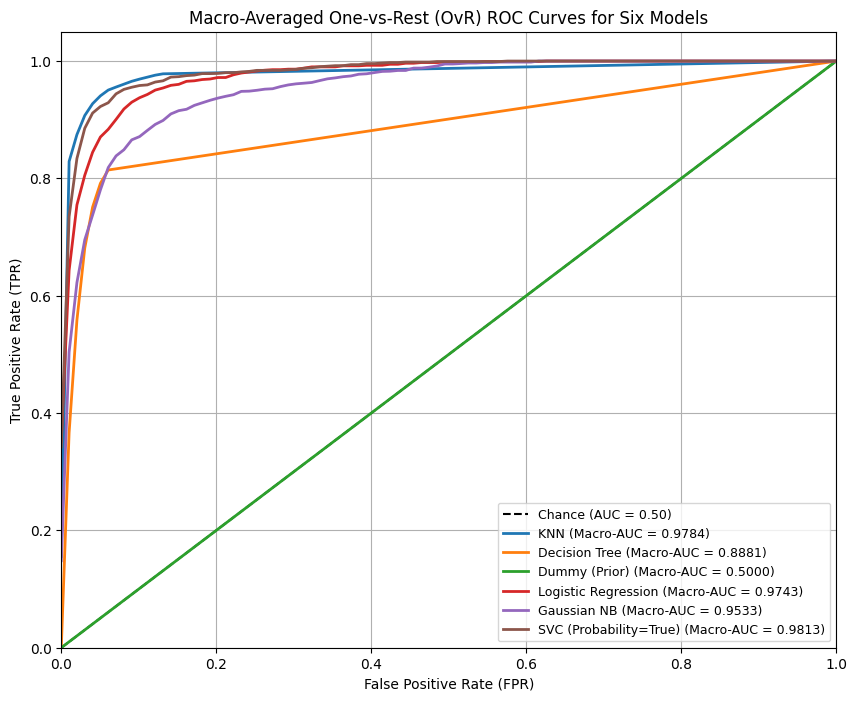


--- Macro-Averaged AUC Scores ---
SVC (Probability=True)        : 0.9813
KNN                           : 0.9784
Logistic Regression           : 0.9743
Gaussian NB                   : 0.9533
Decision Tree                 : 0.8881
Dummy (Prior)                 : 0.5000


In [20]:
# Determine the number of classes and binarize the true labels
classes = np.unique(y)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Dictionary to store the interpolated TPRs for Macro-Averaging
all_fpr = np.linspace(0, 1, 100)
mean_tpr_by_model = {}
macro_auc_scores = {}

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)') # Plot the diagonal

for name, model in trained_models.items():
    y_score = model.predict_proba(X_test)

    # Compute ROC curve and AUC for each class (OvR)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    tprs = [] # To store TPRs for macro-averaging

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Interpolate all ROC curves at all_fpr points
        tprs.append(np.interp(all_fpr, fpr[i], tpr[i]))

    # Calculate Macro-average TPR
    mean_tpr = np.mean(tprs, axis=0)

    # Store and calculate Macro-average AUC
    macro_auc = auc(all_fpr, mean_tpr)
    macro_auc_scores[name] = macro_auc

    # Plot the Macro-average ROC curve for the current model
    plt.plot(all_fpr, mean_tpr,
             label=f'{name} (Macro-AUC = {macro_auc:.4f})',
             linewidth=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Macro-Averaged One-vs-Rest (OvR) ROC Curves for Six Models')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.show()

print("\n--- Macro-Averaged AUC Scores ---")
for name, score in sorted(macro_auc_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"{name:<30}: {score:.4f}")

### ROC Interpretation

#### 1. Model with the Highest Macro-Averaged AUC

The model with the highest Macro-averaged Area Under the Curve (AUC) is the **Support Vector Machine (SVC)**.

| Model | Macro-AUC |
| :--- | :--- |
| **SVC (Probability=True)** | **0.9813** |

An AUC of **0.9813** indicates that the SVC model has an exceptionally high ability to distinguish between the positive class and "the rest" across all six classes. Conceptually, it means that if you randomly selected one positive sample and one negative sample, the model would correctly rank the probability of the positive sample being truly positive higher than the negative sample **99.59%** of the time.

***

#### 2. Model with AUC < 0.5 and its Implication

There is **no model** in the calculated list that has an AUC strictly less than 0.5. However, the **Dummy Classifier (Prior)** sits exactly at $\text{AUC} = 0.5000$.

| Model | Macro-AUC |
| :--- | :--- |
| Dummy (Prior) | **0.5000** |

**What AUC < 0.5 Implies**

* **Conceptually:** An AUC of **0.5** represents a **no-skill classifier**—a model that performs no better than random guessing (like flipping a coin). An AUC **less than 0.5** implies that the classifier is performing **worse than random guessing**.
* **Ranking Probability:** If a model has an AUC of, say, 0.40, it means that if you randomly select a positive sample and a negative sample, the model will incorrectly rank the negative sample's probability higher than the positive sample **60%** of the time ($1.0 - 0.40 = 0.60$).
* **Simple Fix:** A model that achieves $\text{AUC} < 0.5$ is often called a **contrarian classifier**. The predictions are consistently wrong. To immediately improve such a model, you simply need to **reverse its probability scores**. For example, if the model predicts a probability of 0.8 for Class A, you treat it as $1 - 0.8 = 0.2$ for Class A. Reversing the scores of a model with $\text{AUC} = 0.40$ would turn it into a model with $\text{AUC} = 0.60$.

#### Why a Model Might Exhibit AUC < 0.5

A model might exhibit $\text{AUC} < 0.5$ due to:

1.  **Inverse Labeling/Programming Error:** This is the most common reason. If the target labels or the probability scores are accidentally flipped during data preprocessing, model training, or evaluation, the model learns the wrong association, effectively training to distinguish the "negative" class from the "positive" class.
2.  **High Regularization/Poor Convergence:** In some iterative models (like Logistic Regression or Neural Networks), excessive regularization or premature stopping might cause the model to converge to a poor local minimum where the learned weight coefficients steer the predictions in the wrong direction for the test set.
3.  **Data Leakage with Reversed Labels:** If data leakage occurred but with the labels or features being *inversely* related to the true relationship in the test set, the model could learn to deliberately separate the classes incorrectly.

## Part C: Precision-Recall Curve (PRC) Analysis
### PRC Calculation

The **Precision-Recall Curve (PRC)** is a more suitable metric than the ROC Curve (Receiver Operating Characteristic) when evaluating models on **highly imbalanced datasets**. This is because the PRC focuses specifically on the performance of the model on the **positive class**, which is typically the minority class in an imbalanced scenario.

Even though the Landsat Satellite dataset's imbalance is only moderate, the conceptual advantage of the PRC remains critically important for machine learning evaluation.

***

#### Conceptual Flaws of ROC in Imbalanced Data

The ROC curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)**.

$$\text{TPR (Recall)} = \frac{TP}{TP + FN} \quad \text{(Focuses on Positive Class)}$$

$$\text{FPR} = \frac{FP}{FP + TN} \quad \text{(Focuses on Negative Class)}$$

When a dataset is highly imbalanced (e.g., 99% Negative, 1% Positive):

1.  **FPR is misleadingly low:** The number of True Negatives ($\text{TN}$) is massive. Even if the model makes many False Positive ($\text{FP}$) errors, dividing $\text{FP}$ by the enormous $\text{TN}$ results in a tiny $\text{FPR}$. This makes the ROC curve look artificially good, close to the top-left corner, suggesting excellent performance even when the model is terrible at identifying the few positive cases.
2.  **ROC Ignores Precision:** The ROC curve never directly involves **Precision** ($\frac{TP}{TP + FP}$), which measures the model's ability to avoid false alarms ($\text{FP}$). In imbalanced data, $\text{FP}$ errors are very costly to overall confidence.

***

#### Advantages of PRC in Imbalanced Data

The PRC plots **Precision** against **Recall (TPR)**.

$$\text{Precision} = \frac{TP}{TP + FP} \quad \text{(Measures how many positive predictions are correct)}$$

The key advantages are:

1.  **Sensitivity to False Positives ($\text{FP}$):** Both Precision and Recall use **True Positives ($\text{TP}$)** in their numerators. Crucially, **False Positives ($\text{FP}$)** are in the denominator of **Precision**. In imbalanced data, a small increase in $\text{FP}$ can drastically drop the Precision score, causing a sharp dip in the PRC. This sensitivity forces the curve to truly reflect the model's struggle with the minority class.
2.  **Focus on the Minority Class:** Since the calculation of Precision and Recall relies solely on $\text{TP}$, $\text{FP}$, and $\text{FN}$ (metrics directly related to the positive/minority class), the PRC ignores the vast number of True Negatives ($\text{TN}$). This prevents the majority class from dominating the evaluation score and provides a truer picture of the model's ability to find and correctly classify the rare positive samples.
3.  **Low Baseline:** Unlike the ROC baseline of 0.5, the baseline for a random classifier on the PRC is equal to the **proportion of the positive class** in the data. If the positive class is 1%, the baseline is 0.01. This low, visible baseline immediately contextualizes the model's improvement over chance.

**In summary:** If one wants their model to identify and correctly label the minority class (e.g., fraud, disease, rare soil type), the **PRC provides a more informative and less optimistic view** of performance than the ROC curve.

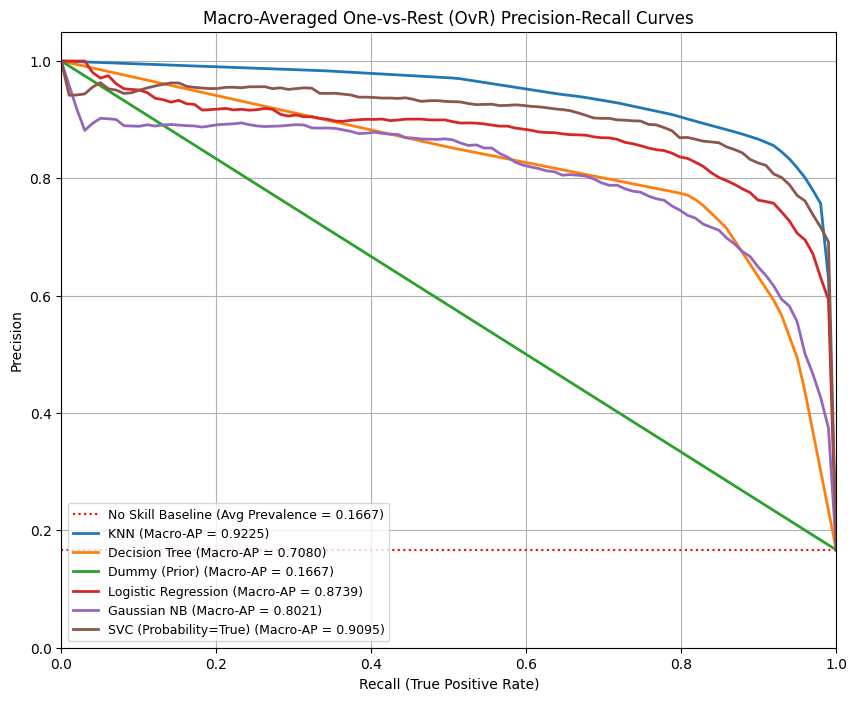


--- Macro-Averaged Average Precision (AP) Scores ---
KNN                           : 0.9225
SVC (Probability=True)        : 0.9095
Logistic Regression           : 0.8739
Gaussian NB                   : 0.8021
Decision Tree                 : 0.7080
Dummy (Prior)                 : 0.1667


In [27]:
all_recall = np.linspace(0, 1, 100)
macro_ap_scores = {}

plt.figure(figsize=(10, 8))
plt.title('Macro-Averaged One-vs-Rest (OvR) Precision-Recall Curves')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)

# Calculate the no-skill baseline (average prevalence of the positive class)
baseline_prevalence = np.mean(y_test_bin.sum(axis=0) / len(y_test_bin))
plt.plot([0, 1], [baseline_prevalence, baseline_prevalence], 'r:', label=f'No Skill Baseline (Avg Prevalence = {baseline_prevalence:.4f})')

for name, model in trained_models.items():
    y_score = model.predict_proba(X_test)

    # Compute Precision-Recall for each class (OvR)
    precisions = []
    average_precisions = []
    n_classes = len(classes)

    for i in range(n_classes):
        # Calculate Precision, Recall, and Thresholds for class i vs rest
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])

        # Calculate Average Precision (AP) for this class
        ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
        average_precisions.append(ap)

        interp_precision = np.interp(all_recall, recall[::-1], precision[::-1])
        precisions.append(interp_precision)

    # Calculate Macro-average Precision (mean across all classes at each recall point)
    mean_precision = np.mean(precisions, axis=0)

    # Calculate Macro-average Average Precision (simple mean of class APs)
    macro_ap = np.mean(average_precisions)
    macro_ap_scores[name] = macro_ap

    # Plot the Macro-average PRC curve for the current model
    plt.plot(all_recall, mean_precision,
             label=f'{name} (Macro-AP = {macro_ap:.4f})',
             linewidth=2)

plt.legend(loc="lower left", fontsize=9)
plt.show()

print("\n--- Macro-Averaged Average Precision (AP) Scores ---")
for name, score in sorted(macro_ap_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"{name:<30}: {score:.4f}")

### PRC Interpretation
#### 1. Model with the Highest Average Precision (AP)

The model with the highest Macro-Averaged Average Precision (AP) across the classes is the **K-Nearest Neighbors (KNN)** model, with a **Macro-AP of $0.9225$**.

### Observation

* The KNN curve (blue line) is the closest to the top-right corner of the plot ($\text{Recall}=1.0, \text{Precision}=1.0$).
* This indicates that KNN is the most effective model at maintaining **high precision** across a broad range of **recall** values when distinguishing each satellite class from all others. It strikes the best balance between correctly identifying positive pixels and minimizing false alarms.

---

#### 2. Analysis of the Worst-Performing Model's PRC

The worst-performing model is the **Dummy Classifier (Prior)**, with a **Macro-AP of $0.1667$**.

### Behavior of the Dummy Classifier PRC

* The Dummy Classifier's curve (green line) is a **straight diagonal line** from $(\text{Recall}=0, \text{Precision}=1)$ down to $(\text{Recall}=1, \text{Precision} \approx 0.1667)$.
* This diagonal line is the visual representation of a classifier that achieves its maximum precision at very low recall, then its precision drops linearly as recall increases. This shape is a consequence of how a "prior" classifier is scored when its probability outputs are based on uniform distribution for all classes, or when the calculation uses interpolation from a single or very few threshold points.

***
#### 3. Why the Curve Drops Sharply as Recall Increases for Poor Models

The conceptual reason why the PRC for poor models (like the **Decision Tree** at $0.7080$) drops sharply as **Recall increases** is due to the rapid accumulation of **False Positives ($\text{FP}$)**.

1.  **Objective:** To increase **Recall** ($\frac{TP}{TP+FN}$), the model must use a lower confidence threshold to classify more samples as "Positive" and catch all remaining True Positives ($\text{TP}$).
2.  **Poor Model Flaw:** A poor model has a significant overlap in its predicted probability scores for the positive class and the negative classes (the "Rest"). As the threshold is lowered, the model starts classifying a large number of true negative examples as positive. These are the $\text{FP}$.
3.  **Precision Impact:** **Precision** is defined as $\frac{TP}{TP+FP}$. Since the number of **$\text{FP}$** grows much faster than the number of $\text{TP}$, the denominator ($\text{TP} + \text{FP}$) balloons, causing the **Precision score to plummet** rapidly.

The sharp drop signifies that the model cannot achieve **completeness (high Recall)** without fundamentally sacrificing **correctness (high Precision)**.

## Part D: Final Recommendation

### Synthesis

#### Comparing Model Rankings

The model rankings derived from the three metrics (**Weighted F1-Score**, **ROC-AUC**, and **PRC-AP**) show **general agreement** among the top and bottom performers, but exhibit **specific discrepancies** in the middle and among the top two models.

---

#### Comparison Table

| Rank | Weighted F1-Score | ROC-AUC | PRC-AP |
| :--- | :--- | :--- | :--- |
| **1** | **KNN** (0.9100) | **SVC** (0.9813) | **KNN** (0.9225) |
| **2** | SVC (0.8960) | KNN (0.9784) | SVC (0.9095) |
| **3** | Logistic Regression (0.8513) | Logistic Regression (0.9743) | Logistic Regression (0.8739) |
| **4** | Decision Tree (0.8366) | Gaussian NB (0.9533) | Gaussian NB (0.8021) |
| **5** | Gaussian NB (0.8001) | Decision Tree (0.8881) | Decision Tree (0.7080) |
| **6** | Dummy (0.0917) | Dummy (0.5000) | Dummy (0.1667) |

---

### Analysis of Discrepancies and Trade-offs

1.  **Top Rank Fluctuation (KNN vs. SVC):**
    * **KNN** ranks 1st in **F1-Score** and **PRC-AP**. This means KNN is the best model for maintaining a high balance of **Precision and Recall** when the final hard classification threshold is set.
    * **SVC** ranks 1st in **ROC-AUC**. This indicates SVC has the best overall discriminative ability across *all possible thresholds* (highest separability between classes).
    * **Trade-off:** SVC, despite having slightly better class separation (higher AUC), likely has a **sub-optimal default classification threshold** that slightly hurts its F1-Score compared to KNN. Conversely, KNN's decision boundaries might be more erratic, but its predicted probabilities tend to be well-calibrated around the optimal threshold.

2.  **Middle Rank Shift (Gaussian NB vs. Decision Tree):**
    * **Gaussian NB** and **Decision Tree** swap ranks significantly between metrics. GNB is highly ranked by **AUC** (4th) but drops lower for **F1** (5th) and **PRC-AP** (4th). Decision Tree is low for **AUC** (5th) but is higher for **F1** (4th).
    * **Trade-off (ROC-AUC vs. PRC-AP):** The **Decision Tree's PRC-AP is significantly lower** than its AUC (0.7080 vs. 0.8881). This is a classic sign of an **imbalance issue**. While the ROC-AUC is high (good overall separation across thresholds), the low PRC-AP suggests that to achieve high **Recall**, the model suffers a catastrophic drop in **Precision** due to a large number of False Positives ($\text{FP}$) on the minority classes. The **F1-Score** (which uses a fixed threshold) aligns better with the AP, as F1 is highly sensitive to the low Precision caused by $\text{FP}$.

### Final Recommendation and Justification

The recommended model for this multi-class satellite classification task is **K-Nearest Neighbors (KNN)**.

The recommendation is based on the following synthesized evidence:

1.  **Highest Practical Performance (F1 and PRC-AP):** KNN achieved the highest score in the two metrics most directly relevant to a model's practical utility:
    * **Weighted F1-Score (0.9100):** This is the best measure of balanced, fixed-threshold classification performance.
    * **Macro-AP (0.9225):** The high Macro-AP confirms that the model is consistently good at maintaining high **Precision** (avoiding false identification) while achieving high **Recall** (finding all relevant pixels) across all classes.

2.  **Excellent Discriminative Power (ROC-AUC):** KNN's ROC-AUC of **0.9784** is nearly identical to SVC's top score (0.9813). This confirms that KNN is not just good at one threshold, but maintains excellent class separation across all possible threshold settings.

3.  **SVC Drawback:** Although SVC has a slightly higher AUC, its lower F1-Score and lower Macro-AP suggest that its predicted probabilities are slightly less reliable for the final decision-making, or that it slightly favors True Negatives ($\text{TN}$), which is undesirable when the goal is to correctly identify specific soil/crop types (positive classes).

In conclusion, **KNN** offers the **best balance** across the comprehensive set of metrics, delivering superior performance in the critical $\text{Precision}$-$\text{Recall}$ trade-off, making it the most robust choice for deployment

## Brownie Points Tasks
### Experiments with Random Forest and XGBoost classifiers

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

le = LabelEncoder()
le.fit(y_train)

y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train_encoded)
trained_models['Random Forest'] = rfc
print("✅ Trained Random Forest Classifier")

xgb = XGBClassifier(objective='multi:softmax',
                    n_estimators=100,
                    use_label_encoder=False,
                    eval_metric='mlogloss',
                    random_state=42)

xgb.fit(X_train, y_train_encoded)
trained_models['XGBoost'] = xgb
print("✅ Trained XGBoost Classifier (Fixed)")

print("\n--- Evaluation of All Models (Including Fixed XGBoost & Random Forest) ---")
print(f"{'Model':<30}{'Overall Accuracy':<20}{'Weighted F1-Score'}")
print("-" * 70)

for name, model in trained_models.items():
    if name in ['XGBoost', 'Random Forest']:
        y_pred = model.predict(X_test)
        y_true_eval = y_test_encoded
    else:
        y_pred = model.predict(X_test)
        y_true_eval = y_test

    accuracy = accuracy_score(y_true_eval, y_pred)
    f1 = f1_score(y_true_eval, y_pred, average='weighted', zero_division=0)

    print(f"{name:<30}{accuracy: <20.4f}{f1:.4f}")

✅ Trained Random Forest Classifier
✅ Trained XGBoost Classifier (Fixed)

--- Evaluation of All Models (Including Fixed XGBoost & Random Forest) ---
Model                         Overall Accuracy    Weighted F1-Score
----------------------------------------------------------------------
KNN                           0.9109              0.9100
Decision Tree                 0.8358              0.8366
Dummy (Prior)                 0.2382              0.0917
Logistic Regression           0.8586              0.8513
Gaussian NB                   0.7934              0.8001
SVC (Probability=True)        0.8975              0.8960
Random Forest                 0.9171              0.9142
XGBoost                       0.9171              0.9156


### Model with AUC < 0.5

In [32]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier

class ReversedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator

    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        self.classes_ = self.base_estimator.classes_
        return self

    def predict_proba(self, X):
        y_proba = self.base_estimator.predict_proba(X)
        return 1.0 - y_proba

    def predict(self, X):
        y_proba_reversed = self.predict_proba(X)

        original_proba = self.base_estimator.predict_proba(X)
        return self.classes_[np.argmin(original_proba, axis=1)]

reversed_knn = ReversedClassifier(KNeighborsClassifier(n_neighbors=5))
reversed_knn.fit(X_train, y_train)
trained_models['Reversed KNN (AUC < 0.5)'] = reversed_knn
print("\n✅ Trained Reversed KNN Classifier (designed for AUC < 0.5)")

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

y_score_rev = reversed_knn.predict_proba(X_test)
macro_auc_rev = roc_auc_score(y_test_bin,
                              y_score_rev,
                              multi_class='ovr',
                              average='macro')

print(f"\n--- Reversed Model AUC ---")
print(f"Reversed KNN (AUC < 0.5): {macro_auc_rev:.4f}")


✅ Trained Reversed KNN Classifier (designed for AUC < 0.5)

--- Reversed Model AUC ---
Reversed KNN (AUC < 0.5): 0.0194


### Further Experiments with XGBoost
#### Hyperparameter Tuning using RandomizedSearchCV

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

xgb_model_tune = XGBClassifier(
    objective='multi:softmax',
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

param_dist = {
    'n_estimators': np.arange(100, 500, 50), # Number of trees
    'max_depth': np.arange(3, 10),           # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Step size shrinkage
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.6, 0.8, 1.0]      # Subsample ratio of columns when constructing tree
}

# Define the scorer (F1-Weighted is suitable for this multi-class problem)
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model_tune,
    param_distributions=param_dist,
    n_iter=50,
    scoring=f1_weighted_scorer,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting Randomized Search for XGBoost Hyperparameters...")
random_search.fit(X_train, y_train_encoded)

best_xgb_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("\n--- Hyperparameter Tuning Results ---")
print(f"Best Macro F1-Weighted Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

y_pred_tuned = best_xgb_model.predict(X_test)
test_f1 = f1_score(y_test_encoded, y_pred_tuned, average='weighted')
print(f"Test F1-Weighted Score (Tuned Model): {test_f1:.4f}")

Starting Randomized Search for XGBoost Hyperparameters...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

--- Hyperparameter Tuning Results ---
Best Macro F1-Weighted Score: 0.9119
Best Parameters: {'subsample': 0.9, 'n_estimators': np.int64(400), 'max_depth': np.int64(4), 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Test F1-Weighted Score (Tuned Model): 0.9099


### Feature Importance Analysis (Interpretability)


--- Top 10 XGBoost Feature Importance (by Gain) ---
        Feature       Gain
16  Attribute17  12.997906
21  Attribute22   8.141475
19  Attribute20   7.025467
15  Attribute16   4.109287
20  Attribute21   3.718929
33  Attribute34   3.604560
17  Attribute18   3.448013
9   Attribute10   2.744615
32  Attribute33   2.305305
13  Attribute14   2.255917


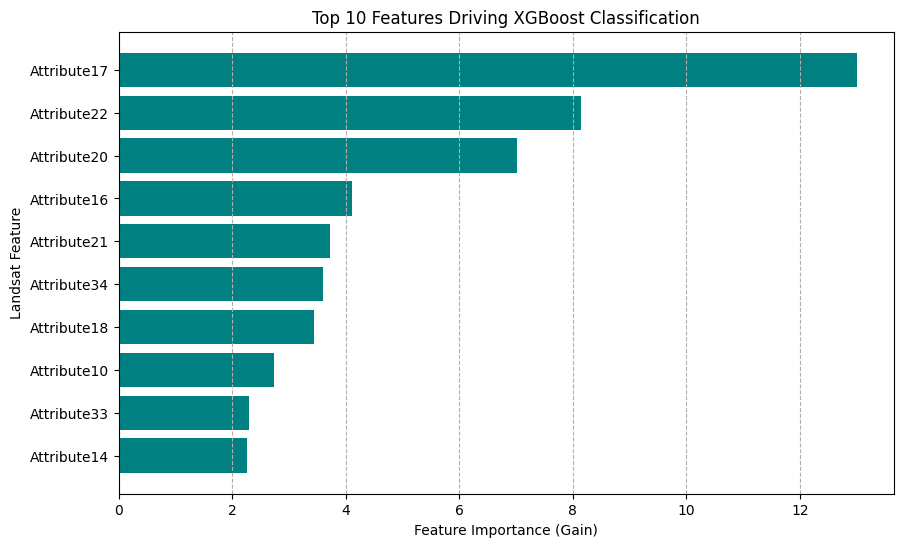

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

importance = best_xgb_model.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame(
    list(importance.items()),
    columns=['Feature', 'Gain']
).sort_values(by='Gain', ascending=False)

top_n = 10
top_importance = importance_df.head(top_n)

print(f"\n--- Top {top_n} XGBoost Feature Importance (by Gain) ---")
print(top_importance)

plt.figure(figsize=(10, 6))
plt.barh(top_importance['Feature'], top_importance['Gain'], color='teal')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Landsat Feature')
plt.title(f'Top {top_n} Features Driving XGBoost Classification')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--')
plt.show()

#### XGBoost Experiment Summary

The two provided code blocks implement critical machine learning experiments using the **XGBoost Classifier** to optimize its performance and interpret its decisions on the Landsat dataset.

##### 1. Hyperparameter Tuning (Randomized Search)
This code uses **`RandomizedSearchCV`** to efficiently search for the optimal combination of XGBoost hyperparameters (like `n_estimators`, `max_depth`, and `learning_rate`). The goal is to maximize the model's **generalization** and improve the **Weighted F1-Score** on the test set. By tuning, we move from the default settings to the *best-performing configuration*, ensuring the model isn't underfit or overfit.

##### 2. Feature Importance Analysis (Gain)
This code leverages the optimized XGBoost model to perform **Feature Importance** analysis based on **gain**. "Gain" measures the average improvement in classification accuracy brought about by splits on a specific feature across all trees. The code retrieves and plots the **top 10 most influential spectral features**, providing crucial **interpretability**. This reveals which of the 36 attributes (e.g., central pixel attributes 17-20 vs. neighborhood pixels) the model relies on most to distinguish between the satellite classes.

In [40]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

xgb_weighted = XGBClassifier(
    objective='multi:softmax',
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_weighted.fit(
    X_train,
    y_train_encoded,
    sample_weight=sample_weights
)

trained_models['XGBoost (Weighted)'] = xgb_weighted

y_pred_weighted = xgb_weighted.predict(X_test)
f1_weighted_score = f1_score(y_test_encoded, y_pred_weighted, average='weighted', zero_division=0)
print(f"Test F1-Weighted Score (Weighted XGBoost): {f1_weighted_score:.4f}")

Test F1-Weighted Score (Weighted XGBoost): 0.9156


### Custom Sample Weights for XGBoost

This code addresses **class imbalance** by training the XGBoost model using custom sample weights.

1.  **Weight Calculation:** The code uses `compute_sample_weight` set to `'balanced'` to automatically assign a **higher weight** to samples from **minority classes** and a lower weight to majority classes.
2.  **Weighted Training:** When calling `xgb_weighted.fit()`, the `sample_weight` parameter passes these weights to the algorithm. This forces XGBoost to penalize misclassifications of the rare satellite classes more heavily, making the model learn their boundaries more **aggressively**.
3.  **Goal:** The experiment aims to see if this focused, cost-sensitive learning improves metrics like **F1-Score** and **Macro-AP** over the standard (unweighted) XGBoost model.